Plan:

- identify missing values
- travel indicator
- impute missing values
- ts
    - decomposition of time series components
        - seasonality
        - trend  
        `decomposition = seasonal_decompose(df_log)`
        - different plots:  
        `fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)`  
        `pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])`  
        `pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])`  
        `pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])`  
    - test for stationarity 
        - the series' mean should not be a function of time; its mean should not drift over time.
        - the series' variance should not be a function of time; its variance should not expand/contract over time (homoskedasticity = variance is not a function of time).  
            `import numpy as np`  
            `import pandas as pd`  
            `from matplotlib import pyplot as plt`  
            `from statsmodels.tsa.stattools import adfuller`  
            `from statsmodels.tsa.seasonal import seasonal_decompose`  
            `from statsmodels.tsa.arima_model import ARIMA`  
            `from pandas.plotting import register_matplotlib_converters`  
            `register_matplotlib_converters()`  
        - check rolling mean (eye test)  
            `rolling_mean = df.rolling(window = 12).mean()`  
            `rolling_std = df.rolling(window = 12).std()`  
            `plt.plot(df, color = 'blue', label = 'Original')`  
            `plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')`  
            `plt.plot(rolling_std, color = 'black', label = 'Rolling Std')`  
            `plt.legend(loc = 'best')`  
            `plt.title('Rolling Mean & Rolling Standard Deviation')`  
            `plt.show()`  
        - adf  
            `result = adfuller(df['Passengers'])`  
            `print('ADF Statistic: {}'.format(result[0]))`  
            `print('p-value: {}'.format(result[1]))`  
            `print('Critical Values:')`  
            `for key, value in result[4].items():`  
            `    print('\t{}: {}'.format(key, value))`  
            - helps decide to difference or not  
            - null hypothesis = unit root (non-stationary)
            - alternative = stationary
            - The null hypothesis for both tests is that the data are non-stationary. We want to REJECT the null hypothesis for this test, so we want a p-value of less that 0.05 (or smaller).
            - getting stationarity and visualizing the chage:  
               `def get_stationarity(timeseries):`  
               - rolling statistics  
               `rolling_mean = timeseries.rolling(window=12).mean()`  
               `rolling_std = timeseries.rolling(window=12).std()`  
               - rolling statistics plot  
               `original = plt.plot(timeseries, color='blue', label='Original')`  
               `mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')`  
               `std = plt.plot(rolling_std, color='black', label='Rolling Std')`  
               `plt.legend(loc='best')`  
               `plt.title('Rolling Mean & Standard Deviation')`  
               `plt.show(block=False)`  
               - Dickey–Fuller test:  
               `result = adfuller(timeseries['Passengers'])`  
               `print('ADF Statistic: {}'.format(result[0]))`  
               `print('p-value: {}'.format(result[1]))`   
               `print('Critical Values:')`  
               `for key, value in result[4].items():`  
                   `print('\t{}: {}'.format(key, value))`  
               
               `df_log_shift = df_log - df_log.shift()`  
               `df_log_shift.dropna(inplace=True)`  
               `get_stationarity(df_log_shift)` 
            - another adf  
            `from statsmodels.tsa.stattools import adfuller`  
            `from numpy import log`  
            `result = adfuller(df.value.dropna())`  
            `print('ADF Statistic: %f' % result[0])`  
            `print('p-value: %f' % result[1])`  
            - adf and kpss  
            `from statsmodels.tsa.stattools import adfuller, kpss`  
            `df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])`  
                 - ADF Test  
                 `result = adfuller(df.value.values, autolag='AIC')`   
                 `print(f'ADF Statistic: {result[0]}')`  
                 `print(f'p-value: {result[1]}')`  
                 `for key, value in result[4].items():`  
                 `print('Critial Values:')`  
                 `print(f'   {key}, {value}')`  
                 - KPSS Test  
                 `result = kpss(df.value.values, regression='c')`  
                 `print('\nKPSS Statistic: %f' % result[0])`  
                 `print('p-value: %f' % result[1])`  
                 `for key, value in result[3].items():`  
                 `print('Critial Values:')`  
                 `print(f'   {key}, {value}')`  
            - another adf  
            `from statsmodels.tsa.stattools import adfuller`  
            `test_result=adfuller(df['Sales'])`  
            `def adfuller_test(sales):`  
            `result=adfuller(sales)`  
            `labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']`  
            `for value,label in zip(result,labels):`  
            `print(label+' : '+str(value) )`  
            - Ho: It is non-stationary  
            - H1: It is stationary  
            `from statsmodels.tsa.stattools import adfuller`  
            `print("p-value:", adfuller(train_array.dropna())[1])` 
            - another adf function  
            `def ad_test(dataset):`  
            `dftest = adfuller(dataset, autolag = 'AIC')`  
            `print("1. ADF : ",dftest[0])`  
            `print("2. P-Value : ", dftest[1])`  
            `print("3. Num Of Lags : ", dftest[2])`  
            `print("4. Num Of Observations Used For ADF Regression:",      dftest[3])`  
            `print("5. Critical Values :")`  
            `for key, val in dftest[4].items():`  
            `print("\t",key, ": ", val)`  
            `adf_test(df['AvgTemp'])`  
    
    - ridding non-stationrity:  
        - Differencing the Series (once or more)
        - If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.
        - If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.
            - Take the log of the series
            - Take the nth root of the series 
            - Combination of the above
            - Differencing the data  
            `df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)`  
            `df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)`  
            `df.head()`  
            - ADF on differenced series  
            `adfuller_test(df['Seasonal First Difference'].dropna())` 
            - plot the differenced series  
            `df['Seasonal First Difference'].plot()` 
        - firstorder differencing  
        `diff_1 = train_array.diff().dropna()`  
        `print("p-value:", adfuller(diff_1.dropna())[1])`  
           
    - pacf (ar)  
        `from pandas.plotting import autocorrelation_plot`  
        `autocorrelation_plot(series)`  
        `pyplot.show()`  (this may be for seasonality, not pacf; this may be acf)
        - another pacf:  
            - PACF plot of 1st differenced series  
            `plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})`  
            `fig, axes = plt.subplots(1, 2, sharex=True)`  
            `axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')`  
            `axes[1].set(ylim=(0,5))`  
            `plot_pacf(df.value.diff().dropna(), ax=axes[1])`  
            `plt.show()`  
        - another pacf and acf  
        `from statsmodels.graphics.tsaplots import plot_acf,plot_pacf`  
        `import statsmodels.api as sm`  
        `fig = plt.figure(figsize=(12,8))`  
        `ax1 = fig.add_subplot(211)`  
        `fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)`  
        `ax2 = fig.add_subplot(212)`  
        `fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)`  
    - acf (ma)  
        `import numpy as np, pandas as pd`  
        `from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`  
        `import matplotlib.pyplot as plt`  
        `plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})`  
        - Import data
        `df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)`  
        - Original Series  
        `fig, axes = plt.subplots(3, 2, sharex=True)`  
        `axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')`  
        `plot_acf(df.value, ax=axes[0, 1])`  
        - 1st Differencing  
        `axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')`  
        `plot_acf(df.value.diff().dropna(), ax=axes[1, 1])`  
        - 2nd Differencing  
        `axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')`  
        `plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])`  
        `plt.show()`
        - another acf:
            `import pandas as pd`  
            `from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`  
            `import matplotlib.pyplot as plt`  
            `plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})`  
            - Import data  
            `df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')`  
            `fig, axes = plt.subplots(1, 2, sharex=True)`  
            `axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')`  
            `axes[1].set(ylim=(0,1.2))`  
            `plot_acf(df.value.diff().dropna(), ax=axes[1])`  
            `plt.show()`  
    - create train/test split
        - test period will be last 10 observations
        `from statsmodels.tsa.stattools import acf`  
        - Create Training and Test  
        `train = df.value[:85]`  
        `test = df.value[85:]`  
        - anotherwayto split dataset  
        `print(df.shape)`   
        `train=df.iloc[:-30]`  
        `test=df.iloc[-30:]`  
        `print(train.shape,test.shape)`  
    - arima  
        - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
            - fit model  
            `model = ARIMA(series, order=(5,1,0))`  
            `model_fit = model.fit()`  
            - summary of fit model  
            `print(model_fit.summary())`
            - line plot of residuals  
            `residuals = DataFrame(model_fit.resid)`  
            `residuals.plot()`  
            `pyplot.show()`  
            - density plot of residuals  
            `residuals.plot(kind='kde')`  
            `pyplot.show()`  
            - summary stats of residuals  
            `print(residuals.describe())`  
            - prediction  
                - "We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’."
                - can also use forecast()  
                    `output = model_fit.forecast()`  
                    `yhat = output[0]`  
        - https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7  
            - fit model  
            `model = ARIMA(df_log, order=(2,1,2))`  
            `results = model.fit(disp=-1)`  
            `plt.plot(df_log_shift)`  
            `plt.plot(results.fittedvalues, color='red')` 
            - in-sample prediction  
            `predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)`  
            `predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()`  
            `predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)`  
            `predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)`  
            `predictions_ARIMA = np.exp(predictions_ARIMA_log)`  
            `plt.plot(df)`  
            `plt.plot(predictions_ARIMA)`  
            - out-of-sample prediction  
            `results.plot_predict(1,264)`  
        - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/  
            `from statsmodels.tsa.arima_model import ARIMA`
            - 1,1,2 ARIMA Model  
            `model = ARIMA(df.value, order=(1,1,2))`  
            `model_fit = model.fit(disp=0)`  
            `print(model_fit.summary())`
            - Plot residual errors  
            `residuals = pd.DataFrame(model_fit.resid)`  
            `fig, ax = plt.subplots(1,2)`  
            `residuals.plot(title="Residuals", ax=ax[0])`  
            `residuals.plot(kind='kde', title='Density', ax=ax[1])`  
            `plt.show()`  
            - Actual vs Fitted  
            `model_fit.plot_predict(dynamic=False)`  
            `plt.show()`  
            - Build Model  
            - model = ARIMA(train, order=(3,2,1))  
            `model = ARIMA(train, order=(1, 1, 1))`  
            `fitted = model.fit(disp=-1)`  
            - Forecast  
            `fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf`  
            - Make as pandas series  
            `fc_series = pd.Series(fc, index=test.index)`  
            `lower_series = pd.Series(conf[:, 0], index=test.index)`  
            `upper_series = pd.Series(conf[:, 1], index=test.index)`  
            - Plot  
            `plt.figure(figsize=(12,5), dpi=100)`  
            `plt.plot(train, label='training')`  
            `plt.plot(test, label='actual')`  
            `plt.plot(fc_series, label='forecast')`  
            `plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)`  
            `plt.title('Forecast vs Actuals')`  
            `plt.legend(loc='upper left', fontsize=8)`  
            `plt.show()` 
        - https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/  
            - For non-seasonal data   
            - p=1, d=1, q=0 or 1  
        `from statsmodels.tsa.arima_model import ARIMA`  
        `model=ARIMA(df['Sales'],order=(1,1,1))`  
        `model_fit=model.fit()`  
        `model_fit.summary()` 
        - auto arima  
        `from statsmodels.tsa.arima_model import ARIMA`  
        `import pmdarima as pm`  
        `df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)`  
        `model = pm.auto_arima(df.value, start_p=1, start_q=1,  
                     ` test='adf',       # use adftest to find optimal 'd'`  
                     ` max_p=3, max_q=3, # maximum p and q`  
                     ` m=1,              # frequency of series`  
                     ` d=None,           # let model determine 'd'`  
                     ` seasonal=False,   # No Seasonality`  
                      `start_P=0, `  
                      `D=0, `  
                      `trace=True,`  
                      `error_action='ignore',  `  
                      `suppress_warnings=True, `  
                     ` stepwise=True)`
                     `print(model.summary())`  
                     
        - another auto arima: https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python  
        `import pmdarima as pmd`  
        `autoarima_model = pmd.auto_arima(timeseriesarray,start_p=1,start_q=1,test="adf",trace=True)`  
        `arima_model.summary()` 
        
        - another auto arima   
        `from pmdarima import auto_arima`  
        `stepwise_fit = auto_arima(df['AvgTemp'], trace=True,`  
        `suppress_warnings=True)`  
        - arima on training dataset
        `from statsmodels.tsa.arima_model import ARIMA`  
        `model=ARIMA(train['AvgTemp'],order=(1,0,5))`  
        `model=model.fit()`  
        `model.summary()`  
        - metrics  
            - Accuracy metrics  
            `def forecast_accuracy(forecast, actual):`  
            `mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE`  
            `me = np.mean(forecast - actual)             # ME`  
            `mae = np.mean(np.abs(forecast - actual))    # MAE`  
            `mpe = np.mean((forecast - actual)/actual)   # MPE`  
            `rmse = np.mean((forecast - actual)**2)**.5  # RMSE`  
            `corr = np.corrcoef(forecast, actual)[0,1]   # corr`  
            `mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)`  
            `maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)`  
            `minmax = 1 - np.mean(mins/maxs)             # minmax`  
            `acf1 = acf(fc-test)[1]                      # ACF1`  
            `return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})`  
            `forecast_accuracy(fc, test.values)`  
            
            - MAPE  
            `def mean_absolute_percentage_error(y_true, y_pred):`    
            `y_true, y_pred = np.array(y_true), np.array(y_pred)`  
            `return np.mean(np.abs((y_true - y_pred) / y_true)) * 100`  
                - predictions  
            `test['ARIMA'] = automodel.predict(len(test))`  
            `test.head(5)`  
                - apply mape  on predictions
                `mean_absolute_percentage_error(test.Sales, test.ARIMA)`
            - more metrics  
            `from sklearn.metrics import mean_squared_error`  
            `from math import sqrt`  
            `test['AvgTemp'].mean()`  
            `rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))`  
            `print(rmse)`  
            
- does covid period make a difference?
    - chow breakpoint test
- if covid time period does make a difference, then ols model of mileage with travel_ind and covid_ind
    - Response variable may need to remain at level, be logged, or differenced. 
- arima with exogenous variables (var model)
    - how to include exogenous variables in ARIMA:
        - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html
    - exogenous variables in auto-arima
        `import pmdarima as pm`  
        - SARIMAX Model  
        `sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],`  
        `start_p=1, start_q=1,`  
        `test='adf',`  
        `max_p=3, max_q=3, m=12,`  
        `start_P=0, seasonal=True,`  
        `d=None, D=1, trace=True,`  
        `error_action='ignore',  `  
        `suppress_warnings=True, `  
        `stepwise=True) `  
        `sxmodel.summary()`  
- some arima forecasting code: https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/ 

- forecasting a plotting the forecast: https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53  
`start=len(train)`  
`end=len(train)+len(test)-1`  
`pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')`  
`pred.plot(legend=True)`  
`test['AvgTemp'].plot(legend=True)`  

### DEV:

In [23]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
pd.options.display.max_rows = 999 # to display all rows
pd.options.display.max_columns = 999 # to display all columns

In [24]:
miles_df = pd.read_csv("Data/Mileage.csv", engine = "python")
miles_df.set_index('Monday',inplace=True)

In [25]:
miles_df

,Mileage,Notes
Monday,,
8/19/2019,293.8,NaN
8/26/2019,955.0,Milwaukee
9/2/2019,167.8,NaN
9/9/2019,411.4,La Crosse
9/16/2019,958.9,Chicago
9/23/2019,87.0,NaN
9/30/2019,130.1,NaN
10/7/2019,1007.5,Chicago
10/14/2019,88.3,NaN


In [26]:
miles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 8/19/2019 to 12/14/2020
Data columns (total 2 columns):
Mileage    69 non-null float64
Notes      12 non-null object
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


### Idenity week(s) where mileage was not recorded

In [27]:
miles_df[miles_df["Mileage"].isnull()]

,Mileage,Notes
Monday,,
3/9/2020,NaN,Car battery died


### How should the missing value be imputed?

In [28]:
miles_df.describe()

,Mileage
count,69.000000
mean,169.723188
std,244.174248
min,0.000000
25%,44.700000
50%,87.000000
75%,150.400000
max,1007.500000


mean? median? or perhaps something more specific?

In [29]:
miles_df.loc[:,"Notes"].unique()

array([nan, 'Milwaukee', 'La Crosse', 'Chicago', 'Car battery died',
       'Milwaukee; Coronavirus begins, 3/11 NBA postponed season',
       'Redwood Falls and Mankato', 'Winona', 'Mankato'], dtype=object)

In [31]:
# identify when travel occurred; notes only exist for travels outside metro area
miles_df["travel_ind"] = np.where(miles_df['Notes'].notnull(), 1, 0)

# car battery died and no travel occurred
miles_df["travel_ind"] = np.where(miles_df['Notes'].str.lower().str.contains("car battery", na = False), 
                                   0, miles_df["travel_ind"])

I travel to Chicago a lot.

In [32]:
miles_df.groupby(["Notes"]).agg({"travel_ind":"count"}).sort_values("travel_ind", ascending = False)

,travel_ind
Notes,
Chicago,5
Car battery died,1
La Crosse,1
Mankato,1
Milwaukee,1
"Milwaukee; Coronavirus begins, 3/11 NBA postponed season",1
Redwood Falls and Mankato,1
Winona,1


Group by `travel_ind` and get average mileage.

In [33]:
grouped_df = miles_df.groupby(["travel_ind"]).agg({"Mileage":["count","mean","median"]})
grouped_df

Mileage                   
             count        mean median
travel_ind                           
0               58   87.389655   73.8
1               11  603.845455  411.4

Imputing values is more of an art than a science. Because this is a time series, we want to try to retain as many observations as possible. Because the median of the series is 87 miles, and the mean of the category of weeks where I didn't travel is about 87 miles, we can feel comfortable imputing a value of approximately 87 for the missing value. 

It won't always be this conclusive when imputing values and reducing bias in the observations, but because the overall median is similar to the mean during non-traveling weeks, the solution is appropriate.  

Let's impute missing values for mileage with mean of weeks where I didn't travel.

In [34]:
# exclude first level of multi-indexed columns resulting from the groupby
grouped_df.columns = grouped_df.columns.droplevel(0)

# get the number to impute the null value in Mileage
non_travel_mean_mileage = grouped_df.loc[0, "mean"].round(1)
non_travel_mean_mileage

87.4

### Impute missing mileage value

In [42]:
miles_df["Mileage"] = np.where(miles_df["Mileage"].isnull(), non_travel_mean_mileage, miles_df["Mileage"]).round(1)

miles_df.loc[["3/2/2020","3/9/2020","3/16/2020"]]

,Mileage,Notes,travel_ind
Monday,,,
3/2/2020,124.6,NaN,0
3/9/2020,87.4,Car battery died,0
3/16/2020,843.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1


Mileage field is ready to be used.

### Histogram

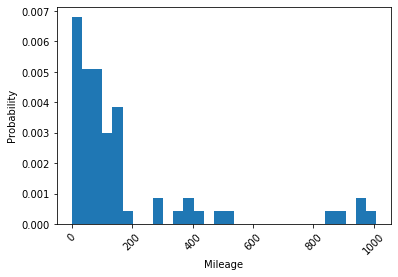

In [43]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Mileage")
plt.xticks(rotation = 45)
plt.show()

### Trend over Time

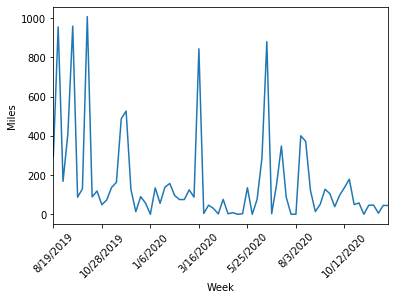

In [44]:
miles_df["Mileage"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

If trend exists, then the series is not staitonary, and will require differencing, at least a difference order of 1.  

Appears to be stationary.

Take the log because the histogram shows a right-skew in the data. 

Add 1 to the level of the Mileage series because you can't take the log(0) ( log(0) = inf). As a result, we scale the level of Mileage by +1.

In [46]:
# can't take log of 0, so offset Mileage by 1 mile
miles_df["Mileage_log"] = np.log(miles_df["Mileage"]+1)

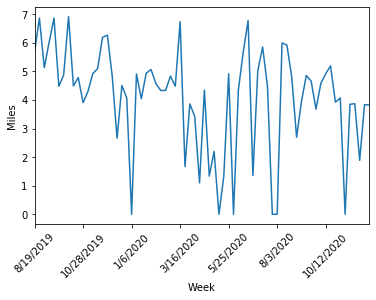

In [48]:
miles_df["Mileage_log"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

### Create Destination Indicators

In [16]:
miles_df["Milwaukee"] = np.where(miles_df['Notes'].str.lower().str.contains("milwaukee", na = False), 1, 0)
miles_df["Chicago"] = np.where(miles_df['Notes'].str.lower().str.contains("chicago", na = False), 1, 0)

### Identifying when Coronovirus started

In [17]:
miles_df.loc[miles_df['Notes'].str.lower().str.contains("coronavirus", na = False)]

,Monday,Mileage,Notes,travel_ind,Milwaukee,Chicago
30,3/16/2020,843.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1,1,0


### Chow Breakpoint Test

test whether one regression or two or more regressions best characterise the data. 

test is capable of detecting "structural breaks" within time-series

In [ ]:
# pip install chowtest

In [18]:
from chow_test import chowtest

In [19]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind"]],
         last_index_in_model_1 = "29",
         first_index_in_model_2 = "30",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 12.752858942889294 p value: 0.0
****************************************************************************************************


(12.752858942889294, 1.1116191744875437e-08)

In [20]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind","Milwaukee","Chicago"]],
         last_index_in_model_1 = "29",
         first_index_in_model_2 = "30",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 8.786592900213678 p value: 0.0
****************************************************************************************************


(8.786592900213678, 2.411714624450667e-06)

### Create Covid Indicator

In [22]:
# change Monday to date column
miles_df["Monday"] = pd.to_datetime(miles_df["Monday"])

# create indicator for Coronavirus period vs non-Coronavirus period
miles_df["covid_ind"] = np.where(miles_df['Monday'] >= "3/16/2020", 1, 0)

miles_df.groupby(["covid_ind"]).agg({"Mileage":["count","mean","median"]})

Mileage                    
            count        mean  median
covid_ind                            
0              30  229.366667  125.05
1              40  122.932500   48.20

### OLS Regression

In [25]:
import statsmodels.api as sm

In [26]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage"]]

In [27]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Mileage   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     70.22
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           6.95e-23
Time:                        14:10:42   Log-Likelihood:                -424.71
No. Observations:                  70   AIC:                             859.4
Df Residuals:                      65   BIC:                             870.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.7746     20.375      7.449      0.000     111.083     192.466
travel_ind   241.0845     56.207      4.289      0.000     128.832     353.337
covid_ind   -115.1122     26.285     -4.379      0.000    -167.608     -62.617
Milwaukee    563.8470     94.066      5.994      0.000     375.983     751.710
Chicago      399.7882     72.792      5.492      0.000     254.412     545.164
==============================================================================
Omnibus:                       17.726   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.613
Skew:                           0.735   Prob(JB):                     9.20e-10
Kurtosis:                       6.480   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage"]]

In [29]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Mileage   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     70.63
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           3.16e-17
Time:                        14:11:52   Log-Likelihood:                -443.53
No. Observations:                  70   AIC:                             893.1
Df Residuals:                      67   BIC:                             899.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.1873     26.220      6.071      0.000     106.853     211.522
travel_ind   526.3451     45.933     11.459      0.000     434.662     618.028
covid_ind   -128.3652     33.780     -3.800      0.000    -195.790     -60.940
==============================================================================
Omnibus:                        8.037   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.861
Skew:                           0.536   Prob(JB):                       0.0119
Kurtosis:                       4.374   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

log Mileage

In [35]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage_log"]]

In [36]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     11.74
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           3.09e-07
Time:                        14:16:24   Log-Likelihood:                -122.03
No. Observations:                  70   AIC:                             254.1
Df Residuals:                      65   BIC:                             265.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4423      0.270     16.460      0.000       3.903       4.981
travel_ind     2.2785      0.745      3.060      0.003       0.792       3.765
covid_ind     -1.3828      0.348     -3.972      0.000      -2.078      -0.687
Milwaukee      0.7712      1.246      0.619      0.538      -1.717       3.260
Chicago        0.6046      0.964      0.627      0.533      -1.321       2.530
==============================================================================
Omnibus:                       14.282   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.618
Skew:                          -1.070   Prob(JB):                     0.000406
Kurtosis:                       3.879   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage_log"]]

In [38]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     23.72
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           1.62e-08
Time:                        14:16:38   Log-Likelihood:                -122.32
No. Observations:                  70   AIC:                             250.6
Df Residuals:                      67   BIC:                             257.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4528      0.267     16.705      0.000       3.921       4.985
travel_ind     2.6950      0.467      5.771      0.000       1.763       3.627
covid_ind     -1.4016      0.343     -4.081      0.000      -2.087      -0.716
==============================================================================
Omnibus:                       13.726   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.811
Skew:                          -1.049   Prob(JB):                     0.000608
Kurtosis:                       3.823   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notes:
    
Mileage is not normally distributed, as expected. I don't regularly travel long distance. Further, driving less during the covid pandemic skews the istribution further. A non-normal distribution makes it harder to capture the pattern in weekly mileage. This is the nature of the data and what we want to explore in the first place, not statistically correct it.

DB-stat

null hypothesis that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process

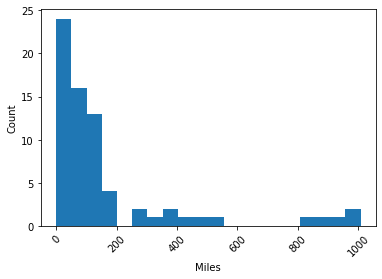

In [51]:
plt.hist(miles_df["Mileage"], density = False, bins = 20)
plt.ylabel("Count")
plt.xlabel("Miles")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Total At Risk")
plt.xticks(rotation = 45)

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["total_at_risk_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged Total At Risk")

plt.tight_layout()
plt.show()

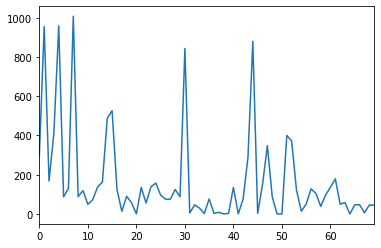

In [43]:
miles_df["Mileage"].plot()
plt.show()

In [52]:
from pandas.plotting import autocorrelation_plot

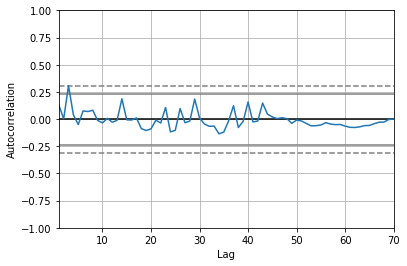

In [53]:
autocorrelation_plot(miles_df["Mileage"])
plt.show()

In [58]:
from statsmodels.tsa.arima_model import ARIMA

In [85]:
ts_model = ARIMA(miles_df["Mileage_log"], order=(3,1,0))
ts_model_fit = ts_model.fit()

In [86]:
print(ts_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Mileage_log   No. Observations:                   69
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -139.792
Method:                       css-mle   S.D. of innovations              1.825
Date:                Tue, 22 Dec 2020   AIC                            289.584
Time:                        15:47:43   BIC                            300.754
Sample:                             1   HQIC                           294.016
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0375      0.089     -0.422      0.675      -0.212       0.137
ar.L1.D.Mileage_log    -0.6797      0.114     -5.943      0.000      -0.904      -0.456
ar.L2.D.Mileage_

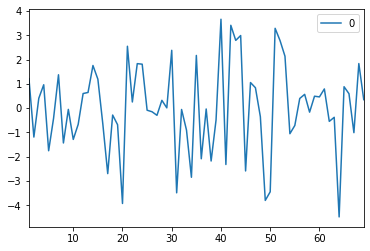

In [87]:
# line plot fo residuals
residuals = pd.DataFrame(ts_model_fit.resid)
residuals.plot()
plt.show()

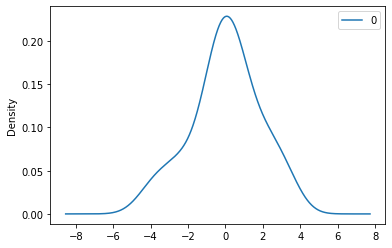

In [88]:
residuals.plot(kind = "kde")
plt.show()

In [89]:
print(residuals.describe())

               0
count  69.000000
mean    0.005217
std     1.841638
min    -4.475151
25%    -0.904485
50%    -0.034308
75%     1.053869
max     3.658634


In [41]:
miles_df

,Monday,Mileage,Notes,travel_ind,Milwaukee,Chicago,covid_ind,Mileage_log
0,2019-08-19,293.8,NaN,0,0,0,0,5.686297
1,2019-08-26,955.0,Milwaukee,1,1,0,0,6.862758
2,2019-09-02,167.8,NaN,0,0,0,0,5.128715
3,2019-09-09,411.4,La Crosse,1,0,0,0,6.021994
4,2019-09-16,958.9,Chicago,1,0,1,0,6.866829
5,2019-09-23,87.0,NaN,0,0,0,0,4.477337
6,2019-09-30,130.1,NaN,0,0,0,0,4.875960
7,2019-10-07,1007.5,Chicago,1,0,1,0,6.916219
8,2019-10-14,88.3,NaN,0,0,0,0,4.492001
9,2019-10-21,118.7,NaN,0,0,0,0,4.784989


In [ ]:
1) impute missing value
2) create travel indicator
3) chow breakpoint test
4) covid indicator
5) ols model with travel indicator and covid indicator
6) arima model
7) arima model with travel indicator and covid indicator